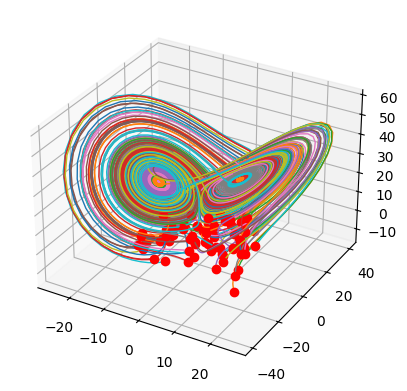

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import torch
import torch.nn as nn
import torch.optim as optim
from mpl_toolkits.mplot3d import Axes3D

# Define the Lorenz system
def lorenz(t, x, sig=10, r=28, b=8/3):
    return [sig * (x[1] - x[0]), r * x[0] - x[1] - x[0] * x[2], x[0] * x[1] - b * x[2]]

# Define the neural network
class FeedforwardNN(nn.Module):
    def __init__(self):
        super(FeedforwardNN, self).__init__()
        self.fc1 = nn.Linear(3, 10)
        self.fc2 = nn.Linear(10, 10)
        self.fc3 = nn.Linear(10, 10)
        self.fc4 = nn.Linear(10, 3)
        self.sigmoid = nn.Sigmoid()
        self.radbas = nn.ReLU()  # PyTorch doesn't have Radial Basis Function, using ReLU as an example
        self.linear = nn.Identity()
        
    def forward(self, x):
        x = self.sigmoid(self.fc1(x))
        x = self.radbas(self.fc2(x))
        x = self.linear(self.fc3(x))
        x = self.fc4(x)
        return x

# Parameters
dt = 0.01
T = 8
t = np.arange(0, T + dt, dt)
n_trajectories = 100

input_data = []
output_data = []

# Generate training data
fig,ax = plt.subplots(1,1,subplot_kw={'projection': '3d'})
for j in range(n_trajectories):
    x0 = 30 * (np.random.rand(3) - 0.5)
    sol = solve_ivp(lorenz, [0, T], x0, t_eval=t, atol=1e-11, rtol=1e-10)
    y = sol.y.T
    input_data.append(y[:-1])
    output_data.append(y[1:])
    ax.plot(y[:, 0], y[:, 1], y[:, 2],linewidth=1)
    ax.plot(x0[0], x0[1], x0[2], 'ro')

input_data = np.vstack(input_data)
output_data = np.vstack(output_data)

# Convert to PyTorch tensors
input_tensor = torch.tensor(input_data, dtype=torch.float32)
output_tensor = torch.tensor(output_data, dtype=torch.float32)




In [2]:
# Define the neural network, loss function, and optimizer
net = FeedforwardNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Train the neural network
n_epochs = 200
batch_size = 32

for epoch in range(n_epochs):
    permutation = torch.randperm(input_tensor.size()[0])
    for i in range(0, input_tensor.size()[0], batch_size):
        indices = permutation[i:i + batch_size]
        batch_input, batch_output = input_tensor[indices], output_tensor[indices]
        
        optimizer.zero_grad()
        outputs = net(batch_input)
        loss = criterion(outputs, batch_output)
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}/{n_epochs}, Loss: {loss.item()}')


Epoch 1/200, Loss: 2.7058942317962646
Epoch 2/200, Loss: 1.326801061630249
Epoch 3/200, Loss: 0.062184784561395645
Epoch 4/200, Loss: 0.04467563331127167
Epoch 5/200, Loss: 0.035394828766584396
Epoch 6/200, Loss: 0.03772785887122154
Epoch 7/200, Loss: 0.03840508684515953
Epoch 8/200, Loss: 0.01573445089161396
Epoch 9/200, Loss: 0.01650119386613369
Epoch 10/200, Loss: 0.002802415983751416
Epoch 11/200, Loss: 0.002847246592864394
Epoch 12/200, Loss: 0.024009212851524353
Epoch 13/200, Loss: 0.018769968301057816
Epoch 14/200, Loss: 0.0035592869389802217
Epoch 15/200, Loss: 0.00598933408036828
Epoch 16/200, Loss: 0.00640850467607379
Epoch 17/200, Loss: 0.0139651820063591
Epoch 18/200, Loss: 0.008764635771512985
Epoch 19/200, Loss: 0.002532704034820199
Epoch 20/200, Loss: 0.008950569666922092
Epoch 21/200, Loss: 0.0052619739435613155
Epoch 22/200, Loss: 0.02961561270058155
Epoch 23/200, Loss: 0.010294239036738873
Epoch 24/200, Loss: 0.020891152322292328
Epoch 25/200, Loss: 0.0169402305036783

Epoch 198/200, Loss: 0.007171691861003637
Epoch 199/200, Loss: 0.005734982434660196
Epoch 200/200, Loss: 0.0014386832481250167


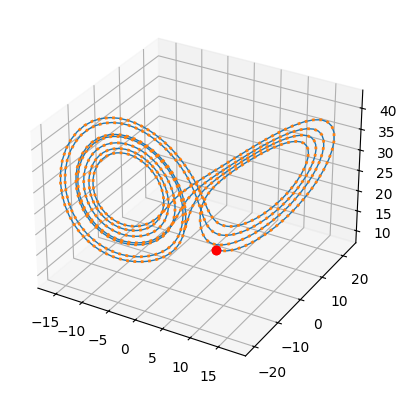

In [8]:
# Testing the trained network
x0 = 20 * (np.random.rand(3) - 0.5)
sol = solve_ivp(lorenz, [0, T], x0, t_eval=t, atol=1e-11, rtol=1e-10)
y = sol.y.T

fig,ax = plt.subplots(1,1,subplot_kw={'projection': '3d'})
ax.plot(y[:, 0], y[:, 1], y[:, 2],linewidth=1)
ax.plot(x0[0], x0[1], x0[2], 'ro')


ynn = [x0]
x0_tensor = torch.tensor(x0, dtype=torch.float32).unsqueeze(0)
for _ in range(1, len(t)):
    y0_tensor = net(x0_tensor)
    ynn.append(y0_tensor.detach().numpy().flatten())
    x0_tensor = y0_tensor

ynn = np.array(ynn)

ax.plot(y[:, 0], y[:, 1], y[:, 2], ':', linewidth=2)
ax.plot(x0[0], x0[1], x0[2], 'ro')

plt.show()



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


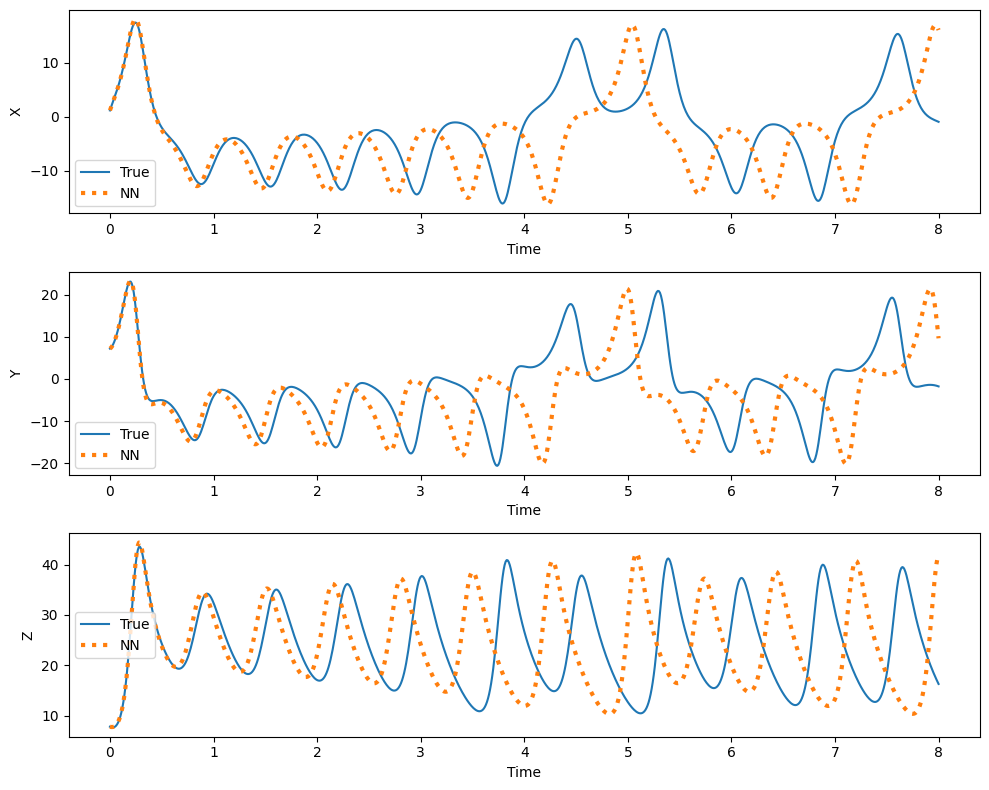

In [13]:
# Plot the comparison of trajectories
fig, axs = plt.subplots(3, 1, figsize=(10, 8))
axs[0].plot(t, y[:, 0], label='True')
axs[0].plot(t, ynn[:, 0], ':', label='NN', linewidth=3)
axs[0].set_xlabel('Time')
axs[0].set_ylabel('X')
axs[0].legend()

axs[1].plot(t, y[:, 1], label='True')
axs[1].plot(t, ynn[:, 1], ':', label='NN', linewidth=3)
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Y')
axs[1].legend()

axs[2].plot(t, y[:, 2], label='True')
axs[2].plot(t, ynn[:, 2], ':', label='NN', linewidth=3)
axs[2].set_xlabel('Time')
axs[2].set_ylabel('Z')
axs[2].legend()

plt.tight_layout()
plt.savefig('lorenz.eps', format='eps', bbox_inches='tight')

plt.show()
